In [1]:
from src.tools import Mapdisplay, random_point_in_shp
import ee
import tensorflow as tf
import geopandas as gpd
from shapely.geometry import Point, Polygon
from folium.plugins import MarkerCluster
import src.tools as tools
import numpy as np
import matplotlib.pyplot as plt
tf.enable_eager_execution()
print('Tensorflow version: ' + tf.__version__)

import folium
print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
ee.Initialize()
%load_ext autoreload
%autoreload 2

Tensorflow version: 1.15.0
Folium version: 0.10.1


### Firstly, we define our prediction area (Camana Valley) and passing to GEE. For moving a vector to GEE, you will use the `ee.Geometry.*` module. The GeoJSON spec describes in detail the type of geometries supported by GEE, including `Point` (a list of coordinates in some projection), `LineString` (a list of points), `LinearRing` (a closed LineString), and Polygon (a list of LinearRings where the first is a shell and subsequent rings are holes). GEE also supports MultiPoint, MultiLineString, and MultiPolygon. The GeoJSON GeometryCollection is also supported, although it has the name MultiGeometry within GEE.

https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb

In [2]:
# 4.4.1 Prediction Area
bbox = gpd.read_file('./data/bbox.json')
xmin, ymin, xmax, ymax = bbox.bounds.values[0]
# Passing a rectangle (prediction area) to Earth Engine
roi = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])
center = roi.centroid().getInfo()['coordinates']
center.reverse()

In [4]:
points = gpd.read_file('./data/sample_points.csv')
points.Latitude = points.Latitude.astype('float')
points.Longitude= points.Longitude.astype('float')
geometry = [Point(xy) for xy in zip(points.Longitude, points.Latitude)]
crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = gpd.GeoDataFrame(points, crs=crs, geometry=geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
points

,id,Longitude,Latitude,geometry
0,a0,-120.171428,39.317559,POINT (-120.17143 39.31756)
1,b1,-120.133422,39.291358,POINT (-120.13342 39.29136)
2,c2,-120.196512,39.344901,POINT (-120.19651 39.34490)
3,d3,-120.278222,39.313033,POINT (-120.27822 39.31303)
4,e4,-120.189553,39.428609,POINT (-120.18955 39.42861)
5,f5,-120.226632,39.401024,POINT (-120.22663 39.40102)
6,g6,-120.289920,39.419390,POINT (-120.28992 39.41939)
7,h7,-120.168496,39.335529,POINT (-120.16850 39.33553)


## Here we change the buffer to match the 30m resolution of Landsat and other variables

In [6]:
#RESOLUTION = 30
PLOT_SIZE = 120
BUFFER = (PLOT_SIZE/2)
p = tools.generate_ee_points(geo_df)
boxes = tools.generate_box_buffer(geo_df, BUFFER)
fc_boxes = boxes['ee_fc']
box = boxes['box_df']

training_list = fc_boxes.toList(fc_boxes.size())
training_pnts = p.toList(p.size())

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
#need to understand the format of these geometries
polyImage = ee.Image(0).byte().paint(fc_boxes, 1).paint(fc_boxes, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})

#map_ex = Mapdisplay(center,{'Truckee':truckee.getInfo()},zoom_start=9)
map_ex = folium.Map([39.3175,-120.171],zoom_start=10)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(map_ex)
#add points
[folium.Marker((p.geometry.y,p.geometry.x),popup=p.id).add_to(map_ex) \
     for _,p in geo_df.iterrows()]
#add boxes
[folium.GeoJson(geom).add_to(map_ex) for geom in box.geometry]
map_ex

## Now we will prepare 3 types of datasets:
1. Topography
2. Climate
3. Landsat

In [17]:
start_date = [2005,6,1]
max_cloud_thr = 5

In [18]:
imgs = tools.get_model_data(roi, start_date, monthwindow=1, max_cloud_thr=max_cloud_thr)

In [16]:
# 4.4.3 Prepare the satellite image (Landsat-8)
# each of these should be bundled into their own function and then 
# we use a merge of them all at the end...

topo = imgs['topo']
climate = imgs['climate']
landsat = imgs['landsat']
'''
sentinel = imgs['sentinel']
naip = imgs['naip']
RGB_bands = ['R','G','B'] #RGB

naip = ee.ImageCollection("USDA/NAIP/DOQQ")\
               .filterBounds(roi)\
               .filterDate('2007-01-01', '2009-12-31')\
               .select(RGB_bands).median()
naip2 = ee.ImageCollection("USDA/NAIP/DOQQ")\
               .filterBounds(roi)\
               .filterDate('2017-01-01', '2019-12-31')\
               .select(RGB_bands).median()
               
YEAR1 = 2010
YEAR2 = 2020
BAND_YEAR1 = [f'{b}_{YEAR1}' for b in BANDS] 
BAND_YEAR2 = [f'{b}_{YEAR2}' for b in BANDS] 
'''

featureStack = ee.Image.cat([
   topo, \
   climate, \
   landsat]).float()

#featureStack = ee.Image.cat([naip2]).float()
#KERNEL_SIZE = BUFFER*4 
KERNEL_SIZE = 12 
lst = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(lst, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)
#EXPORT_BANDS = BAND_YEAR1 + BAND_YEAR2
#EXPORT_BANDS = RGB_bands
EXPORT_BANDS = [b['id'] for b in arrays.getInfo()['bands']]

In [17]:
geomSample = ee.FeatureCollection([])
n = training_pnts.size().getInfo()
batch_num = 1
im_resolution = 30
for g in range(n):
    sample = arrays.sample(\
                           region = ee.Feature(training_pnts.get(g)).geometry(),\
                           scale = im_resolution,\
                           numPixels = 1,\
                           tileScale=8)
    geomSample = geomSample.merge(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


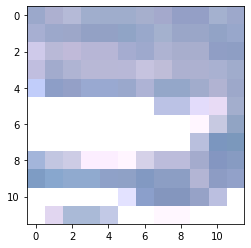

In [163]:
#data check to make sure it looks right
s = geomSample.toList(n)
out = s.get(-1).getInfo()
rband = 'B3_8'
gband = 'B2_8'
bband = 'B1_8'
#scale = 1/10000
scale = 10
r = np.flipud(np.array(out['properties'][rband]))*scale
g = np.flipud(np.array(out['properties'][gband]))*scale
b = np.flipud(np.array(out['properties'][bband]))*scale
rgb = np.array([r,g,b])

plt.imshow(np.moveaxis(rgb, 0,-1))

# now export

In [37]:
# INSERT YOUR BUCKET HERE:
BUCKET = 'csp-sandbox-bucket'
# Specify names locations for outputs in Cloud Storage. 
FOLDER = 'chimera-demo'
TRAINING_BASE = 'aux_patches'
SAMPLE = 'sample_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['R','G','B']
BANDS = opticalBands
#RESPONSE = 'impervious'
FEATURES = EXPORT_BANDS #+ [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 12 
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = fc_boxes.size().getInfo()

#EVAL_SIZE = 8000
# Specify model training parameters.
#BATCH_SIZE = 2 
#EPOCHS = 10
#BUFFER_SIZE = 4
#OPTIMIZER = 'SGD'
#LOSS = 'MeanSquaredError'
#METRICS = ['RootMeanSquaredError']

In [38]:
#get one sample from each polygon from the arrays
geomSample = ee.FeatureCollection([])
n = training_pnts.size().getInfo()
batch_num = 1
im_resolution = 30
for g in range(n):
    sample = arrays.sample(\
                           region = ee.Feature(training_pnts.get(g)).geometry(),\
                           scale = im_resolution,\
                           numPixels = 1,\
                           tileScale=8)
    geomSample = geomSample.merge(sample)
    
desc = f'{TRAINING_BASE}_batch_{batch_num}'
task = ee.batch.Export.table.toCloudStorage(\
    collection = geomSample,\
    description = desc, \
    bucket = BUCKET,\
    fileNamePrefix = FOLDER + '/' + desc,\
    fileFormat = 'TFRecord',\
    selectors = EXPORT_BANDS)
task.start()

## Here we would modify the above cell such that our `featureStacks` are separated by years. 

#### For the case of landsat, it would be a feature stack of 84 bands, that is 7 bands for each month aggregated in 3 year periods. Then we would sample from this to get our specificied sample data for training data

#### Need to implement a feature builder from points rather than just sampling randomly from a polygon

In [39]:
BUFFER_SIZE = 2 #how many pieces of data to pull out at a time
BATCH_SIZE = 3 #size of sample batch
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns: 
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns: 
    A dtuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(EXPORT_BANDS)], stacked[:,:,len(EXPORT_BANDS):]


def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns: 
    A tf.data.Dataset
  """
  glob = tf.gfile.Glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return dataset

#def get_eval_dataset():
#    """Get the preprocessed evaluation dataset
#    Returns: 
#    A tf.data.Dataset of evaluation data.
#    """
#    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*'
#    dataset = get_dataset(glob)
#    dataset = dataset.batch(1).repeat()
#    return dataset

#evaluation = get_eval_dataset()

training = get_training_dataset()

#print(iter(training.take(1)).next())

In [40]:
glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
dataset = get_dataset(glob)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#t = iter(training.take(1)).next()

In [41]:
dataset

<DatasetV1Adapter shapes: ((?, 12, 12, 101), (?, 12, 12, 0)), types: (tf.float32, tf.float32)>

In [43]:
t = iter(training.take(1)).next()
imgs = t[0].numpy()
#plt.imshow(imgs[0,:,:,:]/255)


array([[[[ 1.82524243e+03,  2.99666929e+00,  7.81260071e+01, ...,
           2.59421971e-02,  1.87278427e-02,  0.00000000e+00],
         [ 1.82376892e+03,  2.67835546e+00,  7.34676285e+01, ...,
           3.80966514e-02,  1.79065242e-02,  0.00000000e+00],
         [ 1.82299854e+03,  2.39746141e+00,  7.74844208e+01, ...,
           4.13311794e-02,  2.38212124e-02,  0.00000000e+00],
         ...,
         [ 1.81632349e+03,  2.34256935e+00,  1.23417847e+02, ...,
           2.25891154e-02,  1.51561731e-02,  0.00000000e+00],
         [ 1.81523840e+03,  2.22662711e+00,  1.22065521e+02, ...,
           3.02386824e-02,  2.13122237e-02,  0.00000000e+00],
         [ 1.81475293e+03,  1.77700090e+00,  1.17370155e+02, ...,
           3.19083594e-02,  1.71715170e-02,  1.00000000e+00]],

        [[ 1.82543384e+03,  2.74377060e+00,  8.09867477e+01, ...,
           2.61081662e-02,  1.41129363e-02,  0.00000000e+00],
         [ 1.82396838e+03,  2.76952767e+00,  8.11282425e+01, ...,
           3.04470807e

In [423]:
#looks good. Package it up and repeat this process for the other variables.